# Query SDSS stripe 82 database for multiple observations of same object, make cutouts and co-add, display all together with JPEG cutout.

## This showcases use of locally mounted LARGE SDSS-DAS data
Thanks to Ani Thakar for SQL

In [1]:
# import SciServer libraries
import SciServer.CasJobs
import SciServer.SkyServer as skys

# import custom script for scaling images
import img_scale


# import utility libraries
import pandas
import numpy as np
#import astropy
from astropy.io import fits
from astropy import wcs
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# the query uses a database function that returns th URL of a FITS file containing the detection
# the URL is transformed into a local path that points to the file in the mounted sdss_das public volume.
sql="""
SELECT a.objid as head, c.objid2 as match, b.matchcount, 
       p.fieldid as head_field, d.fieldid as match_field, 
       REPLACE(dbo.fGetUrlFitsCFrame(d.fieldid, 'r'),'http://das.sdss.org','/home/idies/workspace/sdss_das/das2') as fits_r,
       p.ra, d.ra as match_ra, p.dec, d.dec as match_dec
       , p.petror90_r
  from (select top 1 * from galaxy where objId=8658194378960928809) a
   join matchhead b on a.objid=b.objid        -- join with matchhead
   join photoobj p on a.objid=p.objid         -- get matchhead photoobj
   join match c on c.objid1=b.objid           -- join with all the matches
   join photoobjall d on c.objid2=d.objid     -- get match photoobj
order by a.objid                              -- order by matchhead objid
"""
obss = SciServer.CasJobs.executeQuery(sql, "Stripe82")
obss.head(3)

,head,match,matchcount,head_field,match_field,fits_r,ra,match_ra,dec,match_dec,petror90_r
0,8658194378960928809,8658198132761034773,57,8658194378960928768,8658198132761034752,/home/idies/workspace/sdss_das/das2/imaging/64...,18.876797,18.876850,-0.860931,-0.860950,45.09392
1,8658194378960928809,8658195160643076153,57,8658194378960928768,8658195160643076096,/home/idies/workspace/sdss_das/das2/imaging/57...,18.876797,18.876829,-0.860931,-0.860983,45.09392
2,8658194378960928809,8658195113395748890,57,8658194378960928768,8658195113395748864,/home/idies/workspace/sdss_das/das2/imaging/57...,18.876797,18.876855,-0.860931,-0.860946,45.09392


In [3]:
print(obss.fits_r.values)

['/home/idies/workspace/sdss_das/das2/imaging/6484/40/corr/1/fpC-006484-r1-0556.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5792/40/corr/1/fpC-005792-r1-0547.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5781/40/corr/1/fpC-005781-r1-0506.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5770/40/corr/1/fpC-005770-r1-0508.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5765/40/corr/1/fpC-005765-r1-0121.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5759/40/corr/1/fpC-005759-r1-0528.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5744/40/corr/1/fpC-005744-r1-0335.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5709/40/corr/1/fpC-005709-r1-0581.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5658/40/corr/1/fpC-005658-r1-0029.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5642/40/corr/1/fpC-005642-r1-0202.fit.gz'
 '/home/idies/workspace/sdss_das/das2/imaging/5633/40/corr/1/fpC-005633-r1-0542.fit.gz'
 '/home/idies/workspace/sdss_das

In [4]:
# custom function to perform cutout on fits file
def cutout(ff,ra,dec,hw):
    hdulist = fits.open(ff)
    w = wcs.WCS(hdulist[0].header)  
    crd = np.array([[ra,dec]], np.float_)
    pixcoords = np.around(list(w.wcs_world2pix(crd,1))).astype(int)
    sh=hdulist[0].data.shape
    xfrom=max(0,pixcoords[0][1]-hw)
    xto=min(pixcoords[0][1]+hw-1,sh[0])
    yfrom=max(pixcoords[0][0]-hw,0)
    yto=min(pixcoords[0][0]+hw-1,sh[1])
    
    scidata = hdulist[0].data[xfrom:xto,yfrom:yto]
    
    _img=np.zeros((hw*2-1,hw*2-1))
    _mask=np.zeros(_img.shape)
    
    x0=hw-(pixcoords[0][1]-xfrom)
    x1=hw+xto-pixcoords[0][1]
    y0=hw-(pixcoords[0][0]-yfrom)
    y1=hw+yto-pixcoords[0][0]
    _img[x0:x1,y0:y1]=scidata
    _mask[x0:x1,y0:y1]=1
    _img=np.fliplr(_img.T)
    _mask=np.fliplr(_mask.T)
    return _img,_mask


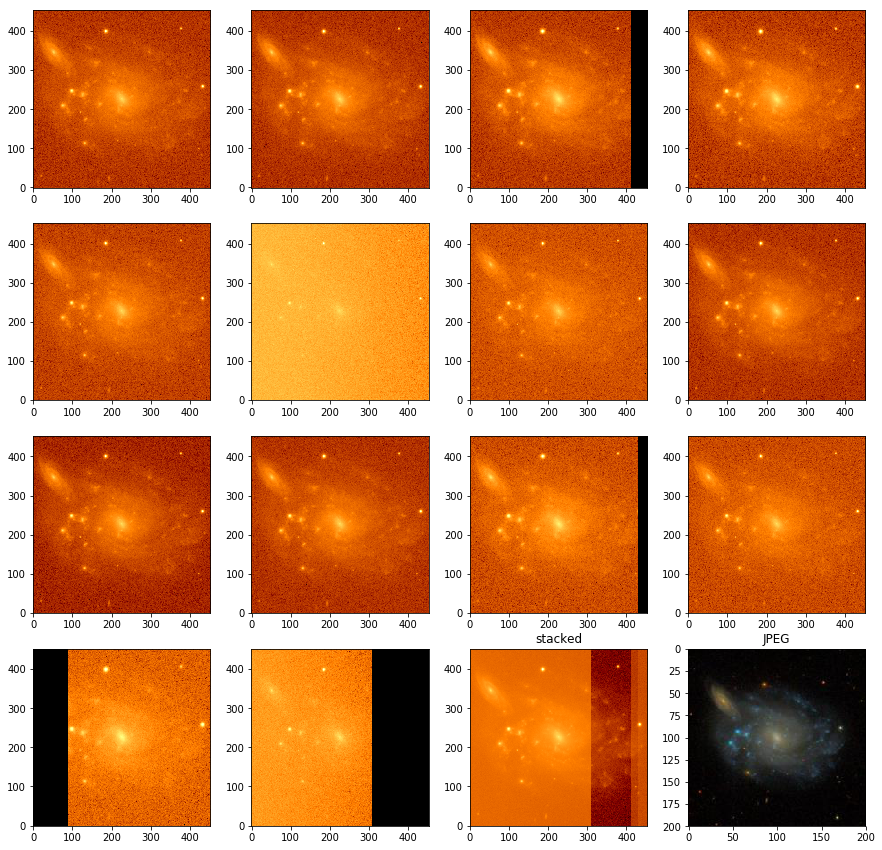

In [5]:
width=200
height=200
pixelsize=0.396

nx=4
ny=4
nmax=nx*ny
plt.figure(figsize=(15, 15*nx/ny))
sp = 1
for ix in range(0,nmax-2):
    if ix == 0: # define fixed parameters and cutout of the JPG image (scaling not quite right)
        r90=obss.petror90_r[ix]
        size=(2*r90/pixelsize)
        scale=size/width
        ra=obss.ra[ix]
        dec=obss.dec[ix]
        jpg_img=skys.getJpegImgCutout(ra=ra, dec=dec, scale=scale, width=width, height=height)

    fimg,_mask=cutout(obss.fits_r[ix],ra,dec,int(np.floor(size)))
    if ix == 0:
        stack = np.zeros(fimg.shape, dtype=float)
        mask = np.zeros(stack.shape, dtype=float)
    stack=stack+fimg
    mask=mask+_mask
    plt.subplot(nx,ny,sp)
    
    scimg=img_scale.asinh(fimg,scale_min=np.min(fimg[_mask>0]))
    im=plt.imshow(scimg,  cmap='afmhot',origin='lower')
    sp+=1
ix=np.where(mask > 0.1)
stack[ix]=stack[ix]/mask[ix]
stack[mask==0]=0
plt.subplot(nx,ny,sp)

scimg=img_scale.asinh(stack,scale_min=np.min(stack[mask>0]))
im=plt.imshow(scimg,cmap='afmhot',origin='lower')
plt.title('stacked')


sp+=1
plt.subplot(nx,ny,sp)
plt.imshow(jpg_img)
plt.title("JPEG");